In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge

In [2]:
sentiment = pd.read_csv('consumer_sentiment.csv')

In [3]:
sentiment

,CASEID,YYYYMM,YYYYQ,YYYY,ID,IDPREV,DATEPR,ICS,ICC,ICE
0,1,197801,19781,1978,1,,,76.71,116.23,51.32
1,2,197801,19781,1978,2,,,121.12,154.08,99.94
2,3,197801,19781,1978,3,,,2.70,2.70,2.70
3,4,197801,19781,1978,4,,,76.71,154.08,27.01
4,5,197801,19781,1978,5,,,121.12,116.23,124.25
...,...,...,...,...,...,...,...,...,...,...
312726,312727,202307,20233,2023,2097,1130,202301,31.60,39.84,26.31
312727,312728,202307,20233,2023,2098,1038,202301,76.01,153.38,26.31
312728,312729,202307,20233,2023,2099,1141,202301,61.21,115.53,26.31
312729,312730,202307,20233,2023,2100,1071,202301,90.81,77.69,99.24


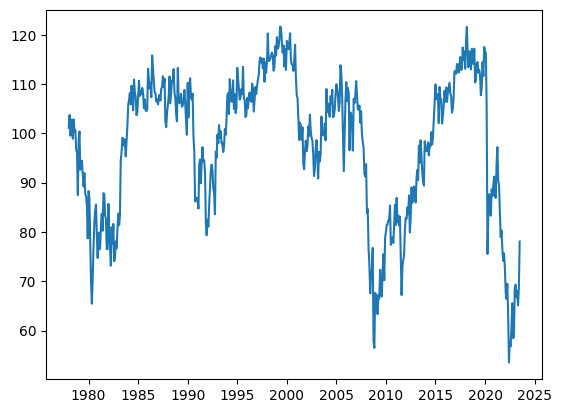

In [4]:
sentiment['DATE'] = pd.to_datetime(sentiment.YYYYMM, format="%Y%m")

sentiment_by_month = sentiment.groupby(['DATE']).ICC.mean()

plt.plot(sentiment_by_month)
plt.show()

In [5]:
unemployment = pd.read_csv("unemployment_rate.csv")
unemployment['DATE'] = pd.to_datetime(unemployment.DATE)
unemployment = unemployment.set_index('DATE')
inflation = pd.read_csv("inflation.csv")
inflation['DATE'] = pd.to_datetime(inflation.DATE)
inflation = inflation.set_index('DATE')
interest_rates = pd.read_csv("interest_rates.csv")
interest_rates['DATE'] = pd.to_datetime(interest_rates['DATE'])
interest_rates = interest_rates.set_index('DATE')

In [22]:
data = pd.DataFrame(data={"sentiment": sentiment_by_month, 
                          "inflation": inflation.CORESTICKM159SFRBATL, 
                          "unemployment": unemployment.UNRATE,
                          "rates": interest_rates.DFF}).dropna()

In [23]:
data['sentiment'] = (data.sentiment - data.sentiment.mean())/data.sentiment.std()
data['unemployment'] = (data.unemployment - data.unemployment.mean())/data.unemployment.std()
data['inflation'] = (data.inflation - data.inflation.mean())/data.inflation.std()
data['rates'] = (data.rates - data.rates.mean())/data.rates.std()

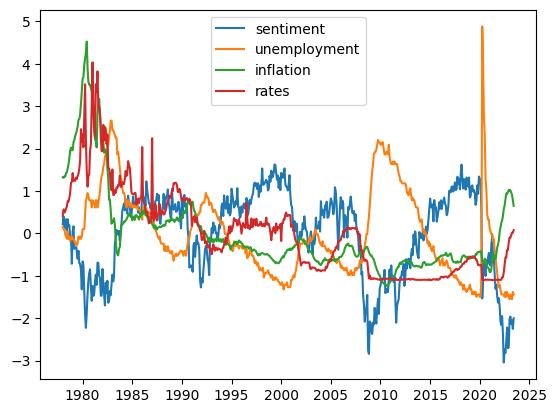

In [24]:
plt.plot(data.sentiment)
plt.plot(data.unemployment)
plt.plot(data.inflation)
plt.plot(data.rates)
plt.legend(['sentiment', 'unemployment', 'inflation', 'rates'])
plt.show()

In [9]:
def try_model(data, cols):
    data = data[cols + ['sentiment']].dropna()
    data_80s = data[data.index < '1990']
    data_precovid = data[data.index < '2020-02-01']
    model_80s = LinearRegression().fit(data_80s[cols], data_80s.sentiment)
    model_precovid = LinearRegression().fit(data_precovid[cols], data_precovid.sentiment)
    model_full = LinearRegression().fit(data[cols], data.sentiment)
    r2 = model_full.score(data[cols], data.sentiment)
    print(f"R2 is {r2:.4}")
    ar2 = 1-(1-r2)/((len(data)-1)/(len(data)-len(cols)-1))
    print(f"Adjusted R2 is {ar2:.4}")
    r2 = model_precovid.score(data_precovid[cols], data_precovid.sentiment)
    print(f"Pre covid R2 is {r2:.4}")
    ar2 = 1-(1-r2)/((len(data_precovid)-1)/(len(data_precovid)-len(cols)-1))
    print(f"Pre covid adjusted R2 is {ar2:.4}")
    max_col = max([len(c) for c in cols])
    print(f"{'Column':{max_col}} {'Coef: Full':>12} {'Coef: Pre-covid':>17} {'Coef: 80s':>11}")
    for col, coef_full, coef_pre, coef_80s in zip(cols, model_full.coef_, model_precovid.coef_, model_80s.coef_):
        print(f"{col:{max_col}} {coef_full:>12.4f} {coef_pre:>17.4f} {coef_80s:>11.4f}")
    plt.plot(data.sentiment)
    plt.plot(data.index, model_80s.predict(data[cols]))
    plt.plot(data.index, model_precovid.predict(data[cols]))
    plt.plot(data.index, model_full.predict(data[cols]))
    plt.axhline(y = 0, color='lightgrey')
    plt.legend(['sentiment', '80s', 'pre-covid', 'full', 'neutral'])
    plt.title(f"Model with {', '.join(cols)}")
    plt.show()

R2 is 0.2918
Adjusted R2 is 0.2944
Pre covid R2 is 0.5533
Pre covid adjusted R2 is 0.5551
Column         Coef: Full   Coef: Pre-covid   Coef: 80s
inflation         -0.2416           -0.1555     -0.5339
unemployment      -0.4574           -0.6731     -0.5328


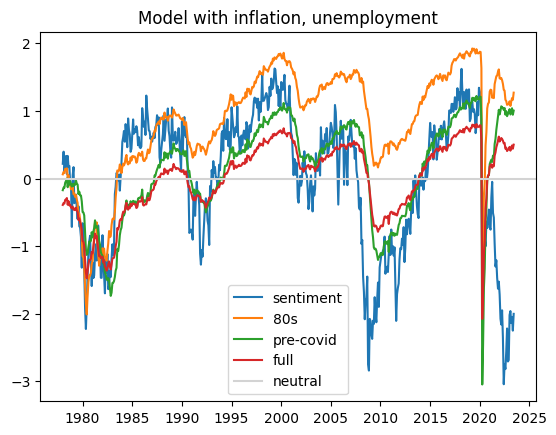

In [10]:
try_model(data, ['inflation', 'unemployment'])

R2 is 0.5007
Adjusted R2 is 0.5034
Pre covid R2 is 0.6431
Pre covid adjusted R2 is 0.6452
Column         Coef: Full   Coef: Pre-covid   Coef: 80s
inflation         -0.8480           -0.5428     -0.4739
unemployment      -0.4866           -0.6686     -0.4948
rates              0.7624            0.4778     -0.1364


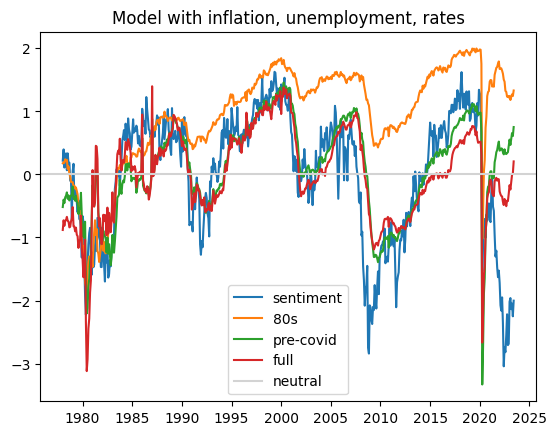

In [11]:
try_model(data, ['inflation', 'unemployment', 'rates'])

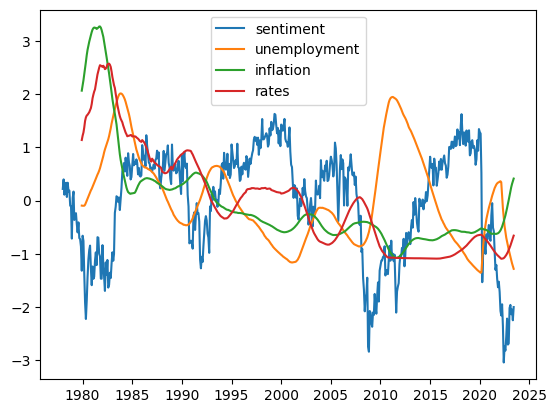

In [12]:
plt.plot(data.sentiment)
plt.plot(data.unemployment.rolling(24).mean())
plt.plot(data.inflation.rolling(24).mean())
plt.plot(data.rates.rolling(24).mean())
plt.legend(['sentiment', 'unemployment', 'inflation', 'rates'])
plt.show()

In [13]:
data['uenmployment_12_month'] = data.unemployment.rolling(12).mean()
data['inflation_12_month'] = data.inflation.rolling(12).mean()
data['rates_12_month'] = data.rates.rolling(12).mean()

R2 is 0.5365
Adjusted R2 is 0.5417
Pre covid R2 is 0.7606
Pre covid adjusted R2 is 0.7635
Column                  Coef: Full   Coef: Pre-covid   Coef: 80s
inflation                  -0.6436           -0.4244     -0.0904
unemployment               -0.5410           -1.9188     -0.7170
rates                       0.3856           -0.1529     -0.1275
uenmployment_12_month       0.0570            1.2839      0.3759
inflation_12_month         -0.3207            0.0380     -0.3990
rates_12_month              0.4983            0.5688      0.0681


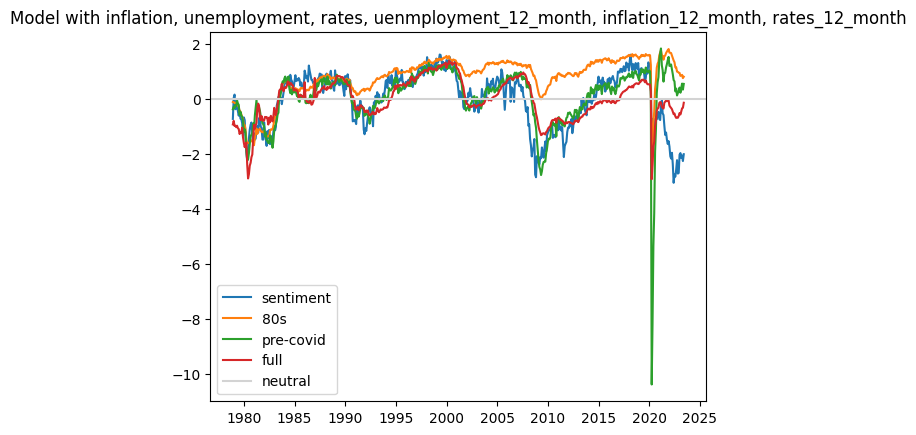

In [14]:
try_model(data, ['inflation', 'unemployment', 'rates', 'uenmployment_12_month', 'inflation_12_month', 'rates_12_month'])

R2 is 0.5364
Adjusted R2 is 0.5417
Pre covid R2 is 0.7645
Pre covid adjusted R2 is 0.7674
Column                  Coef: Full   Coef: Pre-covid   Coef: 80s
inflation                  -0.8310           -0.4809     -0.1817
unemployment               -0.5462           -1.4062     -0.6430
rates                       0.5872           -0.0460     -0.1104
uenmployment_24_month       0.0774            0.7900      0.4205
inflation_24_month         -0.1737            0.1716     -0.2932
rates_24_month              0.3068            0.4037      0.0669


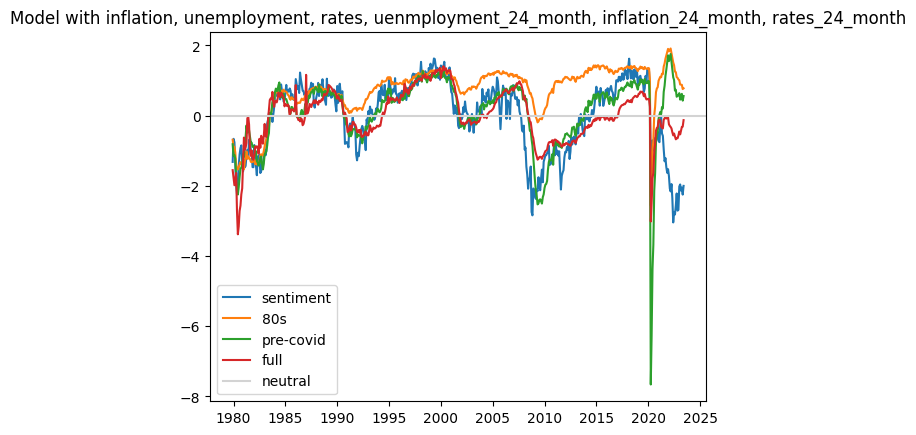

In [15]:
data['uenmployment_24_month'] = data.unemployment.rolling(24).mean()
data['inflation_24_month'] = data.inflation.rolling(24).mean()
data['rates_24_month'] = data.rates.rolling(24).mean()
try_model(data, ['inflation', 'unemployment', 'rates', 'uenmployment_24_month', 'inflation_24_month', 'rates_24_month'])

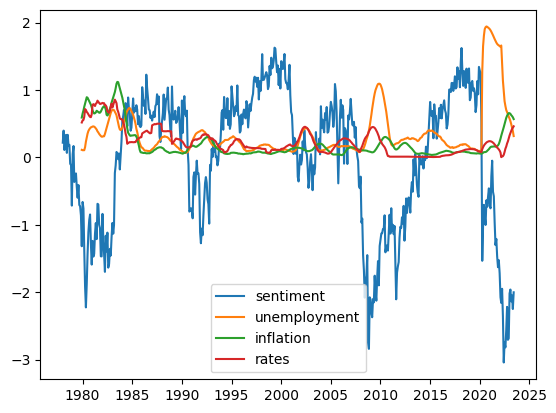

In [16]:
plt.plot(data.sentiment)
plt.plot(data.unemployment.rolling(24).std())
plt.plot(data.inflation.rolling(24).std())
plt.plot(data.rates.rolling(24).std())
plt.legend(['sentiment', 'unemployment', 'inflation', 'rates'])
plt.show()

R2 is 0.6129
Adjusted R2 is 0.6174
Pre covid R2 is 0.6646
Pre covid adjusted R2 is 0.6688
Column                    Coef: Full   Coef: Pre-covid   Coef: 80s
inflation                    -0.7291           -0.5629     -0.4114
unemployment                 -0.2902           -0.6504     -0.3155
rates                         0.8072            0.5720     -0.0646
uenmployment_volatility      -0.5228            0.0271     -0.2034
inflation_volatility         -1.0785            0.4326      0.1566
rates_volatility             -0.5764           -0.9585     -1.4675


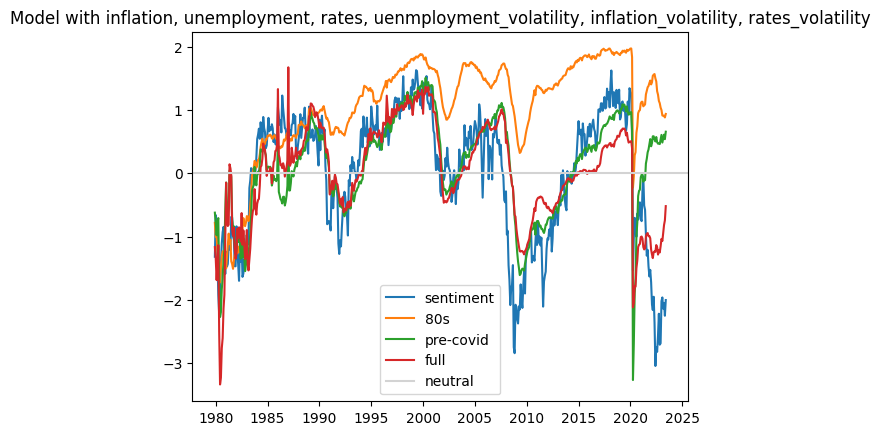

In [17]:
data['uenmployment_volatility'] = data.unemployment.rolling(24).std()
data['inflation_volatility'] = data.inflation.rolling(24).std()
data['rates_volatility'] = data.rates.rolling(24).std()
try_model(data, ['inflation', 'unemployment', 'rates', 'uenmployment_volatility', 'inflation_volatility', 'rates_volatility'])

R2 is 0.4371
Adjusted R2 is 0.4415
Pre covid R2 is 0.5717
Pre covid adjusted R2 is 0.5753
Column                    Coef: Full   Coef: Pre-covid   Coef: 80s
inflation                    -0.1959           -0.2552     -0.4933
unemployment                 -0.2743           -0.7485     -0.4735
uenmployment_volatility      -0.9863           -0.1943      0.2553
inflation_volatility         -0.7177            0.8542     -0.3196


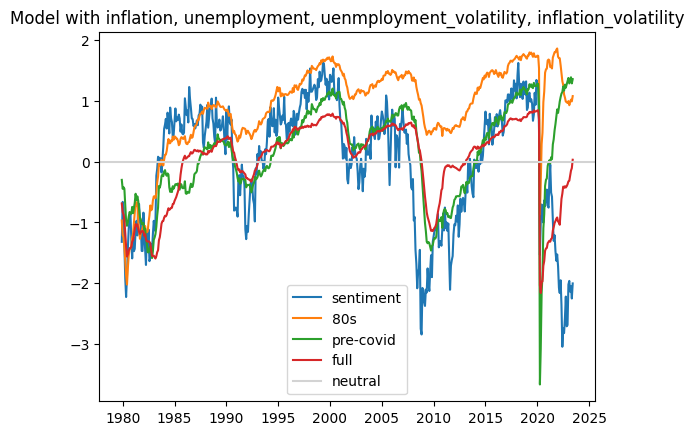

In [18]:
try_model(data, ['inflation', 'unemployment', 'uenmployment_volatility', 'inflation_volatility'])

In [26]:
data['inflation2'] = data.inflation*data.inflation
data['unemployment2'] = data.unemployment*data.unemployment
data['rates2'] = data.rates*data.rates

R2 is 0.5677
Adjusted R2 is 0.5725
Pre covid R2 is 0.6749
Pre covid adjusted R2 is 0.6788
Column          Coef: Full   Coef: Pre-covid   Coef: 80s
inflation          -1.1179           -0.4515     -0.5155
unemployment       -0.3617           -0.5888      0.0646
rates               0.9551            0.5329     -0.0724
inflation2          0.1341           -0.0155     -0.0013
unemployment2      -0.0872           -0.0404     -0.3197
rates2             -0.1839           -0.1085     -0.0253


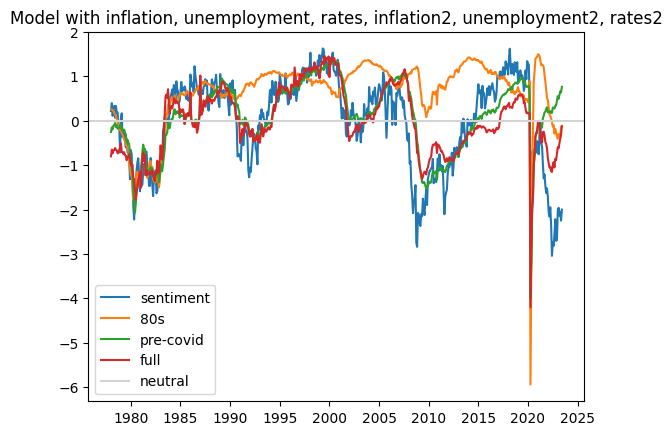

In [27]:
try_model(data, ['inflation', 'unemployment', 'rates', 'inflation2', 'unemployment2', 'rates2'])